### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
# import stanza
# import nltk
# from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from collections import Counter
import time # To time potentially long operations
import spacy
from tqdm.auto import tqdm

### Configuration

In [2]:
# Define file paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..')) # Goes up one level from notebooks/
RAW_DATA_PATH = os.path.join(BASE_DIR, 'data', 'raw', 'NEW.csv')
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'processed_NEW.csv')
ROEMOLEX_WORDS_PATH = os.path.join(BASE_DIR, 'data', 'external', 'roemolex', 'RoEmoLex_V3_pos (sept2021).csv')
ROEMOLEX_EXPR_PATH = os.path.join(BASE_DIR, 'data', 'external', 'roemolex', 'RoEmoLex_V3_expr (sept2021).csv')
VISUALIZATIONS_DIR = os.path.join(BASE_DIR, 'visualizations', 'dataset_analysis')
WORDCLOUD_DIR = os.path.join(VISUALIZATIONS_DIR, 'word_clouds')
EMOTIONAL_WORDCLOUD_DIR = os.path.join(VISUALIZATIONS_DIR, 'emotional_wordclouds')

# Create visualization directories if they don't exist
os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
os.makedirs(WORDCLOUD_DIR, exist_ok=True)
os.makedirs(EMOTIONAL_WORDCLOUD_DIR, exist_ok=True)

# Load Dataset

In [3]:
print(f"\nLoading dataset from: {RAW_DATA_PATH}")
try:
    df = pd.read_csv(RAW_DATA_PATH)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {RAW_DATA_PATH}")
    exit() # Or handle appropriately


Loading dataset from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\data\raw\NEW.csv
Dataset loaded successfully.


In [31]:
# Display basic information
print("\n--- Initial Dataset Info ---")
print(f"Shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())


--- Initial Dataset Info ---
Shape: (5160, 2)

Columns: ['content', 'tag']

Data types:
 content    object
tag        object
dtype: object

First 5 rows:
                                              content             tag
0  atacul iudeilor asupra libertății de exprimare...       fake_news
1  planurile autorităților moldovenești de organi...  misinformation
2  transfuziile cu sânge care provin de la persoa...       fake_news
3  operațiunea militară specială este nouă etapă ...      propaganda
4  joe biden declarat cea mai sfântă dintre sărbă...  misinformation

Missing values:
 content    0
tag        0
dtype: int64


#### Define categories

In [32]:
categories = df['tag'].unique()
print(f"\nExpected categories: {categories}")


Expected categories: ['fake_news' 'misinformation' 'propaganda' 'real_news' 'satire']


# Dataset Description

In [33]:
print("\n--- Dataset Description ---")
print(f"Initial size: {df.shape[0]} rows, {df.shape[1]} columns")

# Analyze category distribution
print("\nCategory distribution (counts):")
category_counts = df['tag'].value_counts()
print(category_counts)

print("\nCategory distribution (percentages):")
category_percentages = df['tag'].value_counts(normalize=True) * 100
print(category_percentages)


--- Dataset Description ---
Initial size: 5160 rows, 2 columns

Category distribution (counts):
tag
fake_news         1032
misinformation    1032
propaganda        1032
real_news         1032
satire            1032
Name: count, dtype: int64

Category distribution (percentages):
tag
fake_news         20.0
misinformation    20.0
propaganda        20.0
real_news         20.0
satire            20.0
Name: proportion, dtype: float64


C:\Users\Razvan\AppData\Local\Temp\ipykernel_17588\2870882821.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", legend=False)



Saved category distribution plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis


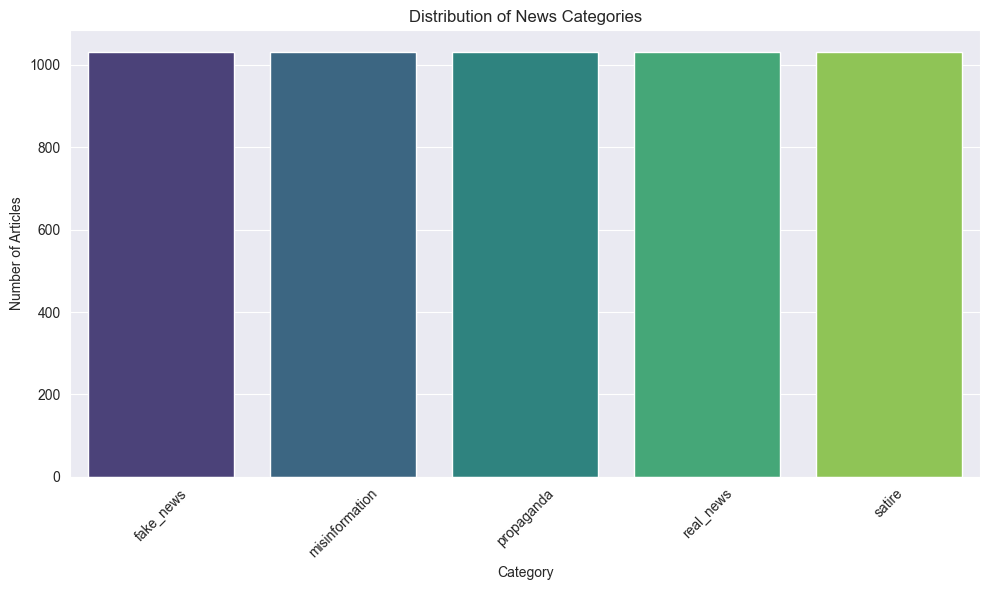

In [34]:
# Visualize category distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", legend=False)
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'category_distribution.png'))
print(f"\nSaved category distribution plot to {VISUALIZATIONS_DIR}")
# plt.show() # Uncomment if running interactively and want to see the plot immediately

# Initial cleaning

In [35]:
print("\n--- Initial Cleaning ---")
print(f"Dataset size before cleaning: {len(df)}")

# 1. Remove duplicate content
# Note: Keep the first occurrence
initial_rows = len(df)
df.drop_duplicates(subset=['content'], keep='first', inplace=True)
rows_after_duplicates = len(df)
print(f"Removed {initial_rows - rows_after_duplicates} duplicate articles based on 'content'.")
print(f"Dataset size after removing duplicates: {len(df)}")

# 2. Remove content with less than 50 characters
MIN_CONTENT_LENGTH = 50
initial_rows_before_len_filter = len(df)
df = df[df['content'].str.len() >= MIN_CONTENT_LENGTH]
rows_after_len_filter = len(df)
print(f"Removed {initial_rows_before_len_filter - rows_after_len_filter} articles with content length < {MIN_CONTENT_LENGTH} characters.")
print(f"Final dataset size after initial cleaning: {len(df)}")

# Verify category distribution after cleaning
print("\nCategory distribution after cleaning:")
print(df['tag'].value_counts())
print("\nCategory distribution (percentages) after cleaning:")
print(df['tag'].value_counts(normalize=True) * 100)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

print("\nInitial cleaning complete.")


--- Initial Cleaning ---
Dataset size before cleaning: 5160
Removed 819 duplicate articles based on 'content'.
Dataset size after removing duplicates: 4341
Removed 7 articles with content length < 50 characters.
Final dataset size after initial cleaning: 4334

Category distribution after cleaning:
tag
real_news         1032
misinformation     916
satire             870
fake_news          812
propaganda         704
Name: count, dtype: int64

Category distribution (percentages) after cleaning:
tag
real_news         23.811721
misinformation    21.135210
satire            20.073835
fake_news         18.735579
propaganda        16.243655
Name: proportion, dtype: float64

Initial cleaning complete.


# Load spaCy Romanian Model

In [9]:
# We'll try the large model for potentially better accuracy.
# Ensure it's downloaded: python -m spacy download ro_core_news_lg

In [27]:
!pip install spacy

  Obtaining dependency information for spacy from https://files.pythonhosted.org/packages/9f/85/efec3c8047014223399b66dfa44ac0b616b46be083947bd67be15f52a78a/spacy-3.8.5-cp312-cp312-win_amd64.whl.metadata
  Using cached spacy-3.8.5-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Obtaining dependency information for murmurhash<1.1.0,>=0.28.0 from https://files.pythonhosted.org/packages/b2/66/7d74a9f547dd719e86245e2a3d126140335861b8e362bdd22c7f9842a2b8/murmurhash-1.0.12-cp312-cp312-win_amd64.whl.metadata
  Using cached murmurhash-1.0.12-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
  Obtaining dependency information for preshed<3.1.0,>=3.0.2 from https://files.pythonhosted.org/packages/db/e4/d074efb7e8a8873d346d2fb8dd43e19b1eae0697351c0d79cff947cba46e/preshed-3.0.9-cp312-cp312-win_amd64.whl.metadata
  Using cached preshed-3.0.9-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
  Obtaining dependency information for thinc<8.4.0,>=8.3.4 from https://files.pythonhosted.org/packages/58/08/5439dd15b66161

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Razvan\\projects\\university\\fkn-ds-an\\venv\\Lib\\site-packages\\numpy\\fft\\_pocketfft_umath.cp312-win_amd64.pyd'
Check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import spacy

SPACY_MODEL_NAME = "ro_core_news_lg"
print(f"\n--- Loading spaCy model: {SPACY_MODEL_NAME} ---")
try:
    # Disable components we might not need initially for speed, enable if needed later
    # We need 'tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'
    # We don't strictly need 'parser' for this task, could disable it.
    nlp = spacy.load(SPACY_MODEL_NAME, disable=[]) # Load all components for now
    print(f"spaCy model '{SPACY_MODEL_NAME}' loaded successfully.")
except OSError:
    print(f"Error: spaCy model '{SPACY_MODEL_NAME}' not found.")
    print(f"Please download it by running: python -m spacy download {SPACY_MODEL_NAME}")
    # Depending on your setup, you might want to stop execution here
    nlp = None # Set nlp to None to indicate failure
except Exception as e:
    print(f"An unexpected error occurred loading the spaCy model: {e}")
    nlp = None

# Proceed only if the model loaded successfully
if nlp:
    print(f"\n--- Applying spaCy Preprocessing ---")
    print("This may take a while...")

    # Increase max length if documents are very long (default is 1,000,000 chars)
    # nlp.max_length = 2000000 # Uncomment and adjust if you get length errors

    # Use tqdm for progress tracking with pandas apply
    tqdm.pandas(desc="spaCy Processing")

    # Process texts in batches using nlp.pipe for efficiency
    processed_docs = []
    batch_size = 100 # Adjust batch size based on memory/performance
    start_time = time.time()

    for doc in tqdm(nlp.pipe(df['content'], batch_size=batch_size), total=len(df), desc="Processing Texts"):
        # Extract lemmas (non-stopword, non-punctuation, alphabetic, prepositions, conjunctions)
        lemmas_filtered = [
            token.lemma_.lower() for token in doc
            if not token.is_stop 
            and not token.is_punct 
            and token.is_alpha
            and token.pos_ not in {"ADP", "CCONJ", "SCONJ"}
        ]
        # Extract all lemmas (for potential later use)
        all_lemmas = [token.lemma_.lower() for token in doc]
        # Extract POS tags
        pos_tags = [token.pos_ for token in doc]
         # Extract NER entities (text and label)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        processed_docs.append({
            'lemmas_filtered': lemmas_filtered,
            'all_lemmas': all_lemmas,
            'pos_tags': pos_tags,
            'entities': entities
        })

    end_time = time.time()
    print(f"spaCy processing finished in {end_time - start_time:.2f} seconds.")

    # Create new columns from the processed data
    print("\nAdding processed columns to DataFrame...")
    processed_df = pd.DataFrame(processed_docs)
    df['lemmas'] = processed_df['all_lemmas'] # Column with all lemmas
    df['lemmas_filtered'] = processed_df['lemmas_filtered'] # Column with stopwords/punct removed
    df['pos_tags'] = processed_df['pos_tags']
    df['entities'] = processed_df['entities']

    # Display the DataFrame with new columns
    print("\nDataFrame with new spaCy columns:")
    print(df[['content', 'tag', 'lemmas_filtered', 'pos_tags', 'entities']].head())

    # --- Save Processed Data ---
    print(f"\n--- Saving Processed Data ---")
    try:
        # Select columns to save (optional, save all if preferred)
        columns_to_save = ['content', 'tag', 'lemmas', 'lemmas_filtered', 'pos_tags', 'entities']
        df[columns_to_save].to_csv(PROCESSED_DATA_PATH, index=False, encoding='utf-8')
        print(f"Processed data saved successfully to: {PROCESSED_DATA_PATH}")
    except Exception as e:
        print(f"Error saving processed data: {e}")

else:
    print("\nSkipping spaCy preprocessing because the model could not be loaded.")


--- Loading spaCy model: ro_core_news_lg ---
spaCy model 'ro_core_news_lg' loaded successfully.

--- Applying spaCy Preprocessing ---
This may take a while...


Processing Texts:   0%|          | 0/4334 [00:00<?, ?it/s]

spaCy processing finished in 171.84 seconds.

Adding processed columns to DataFrame...

DataFrame with new spaCy columns:
                                             content             tag  \
0  atacul iudeilor asupra libertății de exprimare...       fake_news   
1  planurile autorităților moldovenești de organi...  misinformation   
2  transfuziile cu sânge care provin de la persoa...       fake_news   
3  operațiunea militară specială este nouă etapă ...      propaganda   
4  joe biden declarat cea mai sfântă dintre sărbă...  misinformation   

                                     lemmas_filtered  \
0  [atac, iudeilor, libertate, exprimare, continu...   
1  [plan, autoritate, moldovenesc, organiza, refe...   
2  [transfuziă, sânge, proveni, persoană, vaccina...   
3  [operațiune, militar, special, etapă, luptă, e...   
4  [joe, biden, declarat, sfânt, sărbătoare, creș...   

                                            pos_tags  \
0  [NOUN, NOUN, ADP, NOUN, ADP, NOUN, ADJ, SCONJ,...

# Load Processed Data

In [4]:
import ast

print(f"\n--- Loading Processed Data ---")
try:
    # Define converters to parse list-like columns correctly
    def parse_list_literal(x):
        try:
            # Check if it's already a list (e.g., if notebook kernel was kept alive)
            if isinstance(x, list):
                return x
            # Safely evaluate string representation of list
            return ast.literal_eval(x)
        except (ValueError, SyntaxError, TypeError):
            # Handle potential errors or empty values, return empty list
            return []

    converters = {
        'lemmas': parse_list_literal,
        'lemmas_filtered': parse_list_literal,
        'pos_tags': parse_list_literal,
        'entities': parse_list_literal
    }
    df_processed = pd.read_csv(PROCESSED_DATA_PATH, converters=converters)
    print(f"Processed data loaded successfully from: {PROCESSED_DATA_PATH}")
    print(f"Shape: {df_processed.shape}")
    print("Data types:\n", df_processed.dtypes) # Verify list columns are now 'object' containing lists
    print("\nChecking first row's list types:")
    print(f"Type of lemmas_filtered in row 0: {type(df_processed['lemmas_filtered'].iloc[0])}")
    print(f"Type of entities in row 0: {type(df_processed['entities'].iloc[0])}")

except FileNotFoundError:
    print(f"Error: Processed data file not found at {PROCESSED_DATA_PATH}")
    print("Please ensure the previous spaCy processing step completed successfully.")
    # Exit or handle appropriately if file is missing
    df_processed = None
except Exception as e:
    print(f"An error occurred loading the processed data: {e}")
    df_processed = None


--- Loading Processed Data ---
Processed data loaded successfully from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\data\processed\processed_NEW.csv
Shape: (4334, 6)
Data types:
 content            object
tag                object
lemmas             object
lemmas_filtered    object
pos_tags           object
entities           object
dtype: object

Checking first row's list types:
Type of lemmas_filtered in row 0: <class 'list'>
Type of entities in row 0: <class 'list'>


### Basic Statistics Calculation


--- Basic Statistics Calculation ---
Added 'word_count' column (based on filtered lemmas).

Word Count Statistics per Category:
                      mean  median  min   max         std
tag                                                      
fake_news       154.366995    60.0    6  1796  266.295884
misinformation  150.274017    64.0    9   798  174.789767
propaganda      145.406250    40.0    9  1400  217.858828
real_news        82.563953    33.0    7   768  116.252075
satire           61.078161    64.0    7   370   42.090438


C:\Users\Razvan\AppData\Local\Temp\ipykernel_1368\3255069836.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='tag', y='word_count', palette="viridis", showfliers=False) # Hide outliers for better view of boxes



Saved word count boxplot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis
Saved word count histogram to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis

--- Vocabulary Size Calculation ---

Vocabulary Size (Unique Filtered Lemmas) per Category:
fake_news         11771
real_news         10699
propaganda         9659
misinformation     7786
satire             4847
dtype: int64

Overall unique filtered lemmas across all categories: 25146


C:\Users\Razvan\AppData\Local\Temp\ipykernel_1368\3255069836.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vocab_series.index, y=vocab_series.values, palette="viridis")



Saved vocabulary size barplot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis


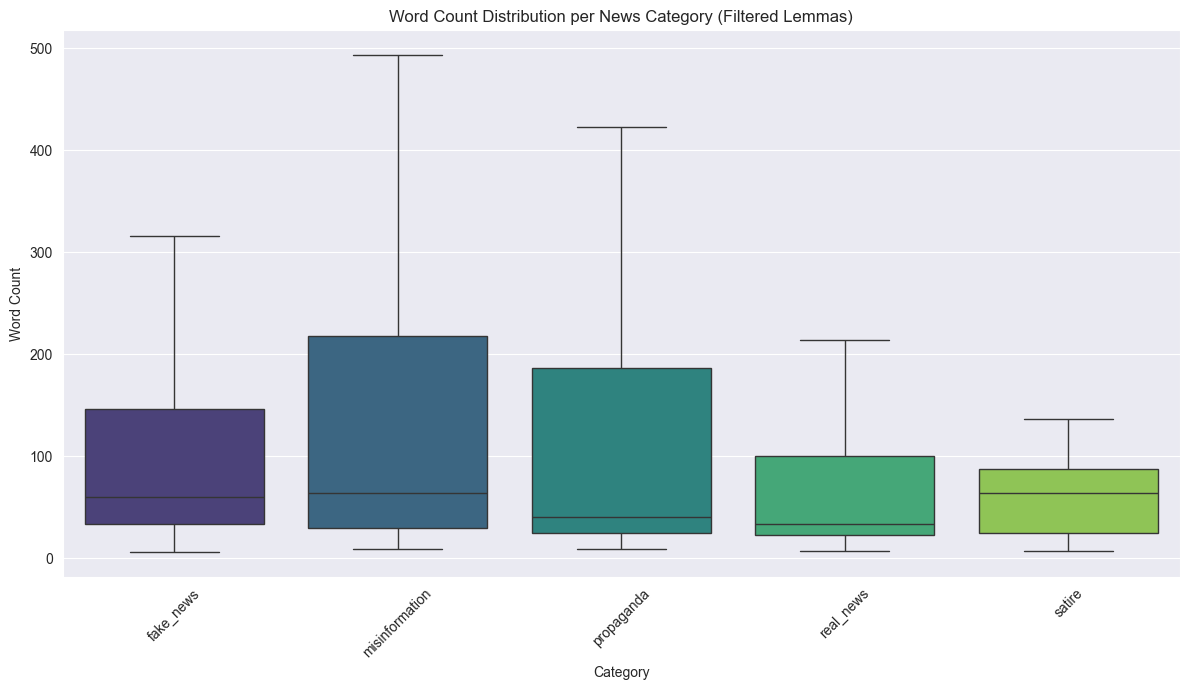

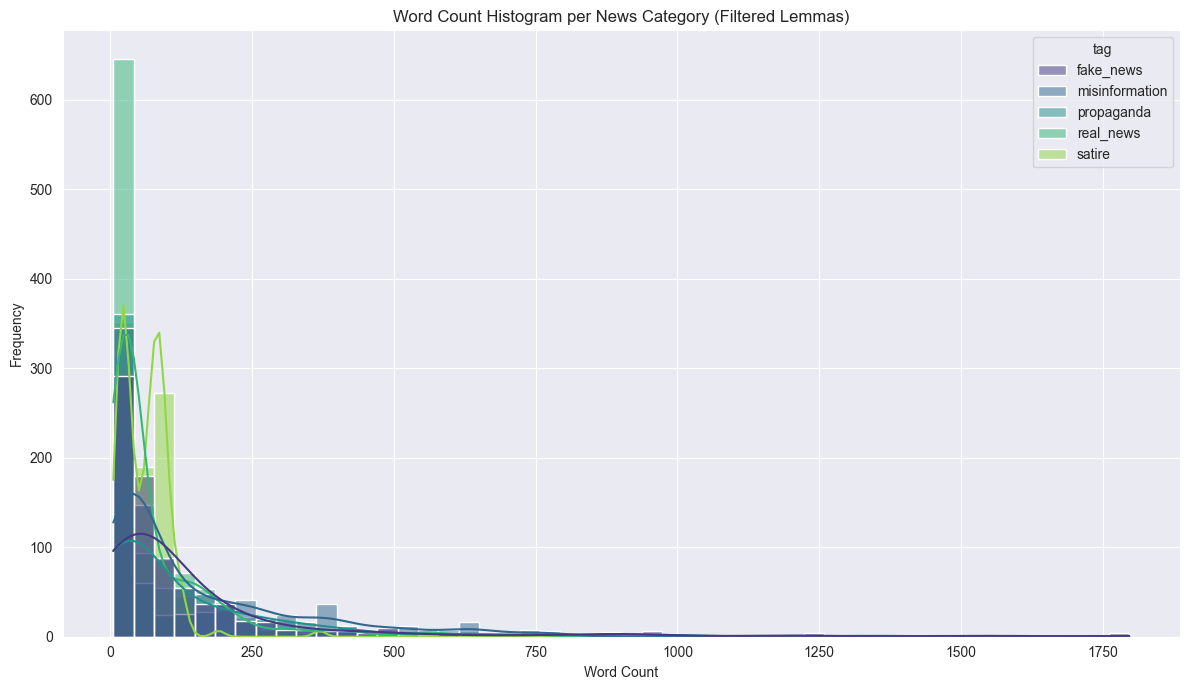

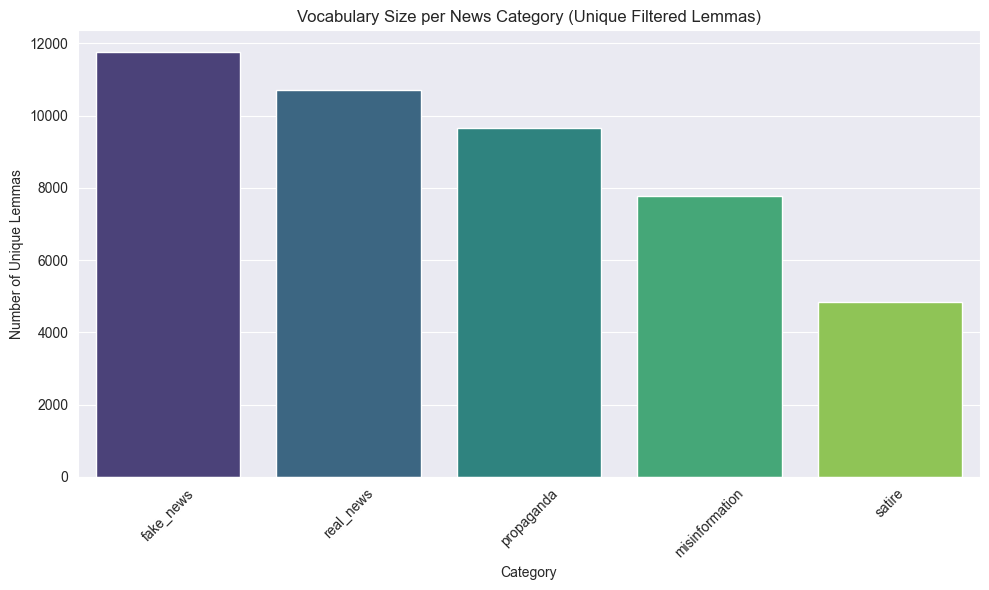

In [5]:
# Proceed only if data loaded successfully
if df_processed is not None:
    print("\n--- Basic Statistics Calculation ---")

    # 1. Calculate Word Count (based on filtered lemmas)
    df_processed['word_count'] = df_processed['lemmas_filtered'].apply(len)
    print("Added 'word_count' column (based on filtered lemmas).")

    # 2. Analyze Word Count per Category
    print("\nWord Count Statistics per Category:")
    word_count_stats = df_processed.groupby('tag')['word_count'].agg(['mean', 'median', 'min', 'max', 'std'])
    print(word_count_stats)

    # 3. Visualize Word Count Distribution per Category
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_processed, x='tag', y='word_count', palette="viridis", showfliers=False) # Hide outliers for better view of boxes
    plt.title('Word Count Distribution per News Category (Filtered Lemmas)')
    plt.xlabel('Category')
    plt.ylabel('Word Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'word_count_boxplot.png'))
    print(f"\nSaved word count boxplot to {VISUALIZATIONS_DIR}")
    # plt.show()

    plt.figure(figsize=(12, 7))
    sns.histplot(data=df_processed, x='word_count', hue='tag', kde=True, palette="viridis", bins=50)
    plt.title('Word Count Histogram per News Category (Filtered Lemmas)')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    # Limit x-axis if distribution is highly skewed (optional)
    # plt.xlim(0, word_count_stats['max'].max() / 2) # Example limit
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'word_count_histogram.png'))
    print(f"Saved word count histogram to {VISUALIZATIONS_DIR}")
    # plt.show()


    # 4. Calculate Vocabulary Size per Category (Unique Filtered Lemmas)
    print("\n--- Vocabulary Size Calculation ---")
    vocabulary_sizes = {}
    all_filtered_lemmas = set() # To calculate overall vocabulary

    for category in df_processed['tag'].unique():
        # Concatenate all lists of lemmas_filtered for the current category
        lemmas_in_category = df_processed[df_processed['tag'] == category]['lemmas_filtered'].sum()
        # Find unique lemmas and count them
        unique_lemmas = set(lemmas_in_category)
        vocabulary_sizes[category] = len(unique_lemmas)
        all_filtered_lemmas.update(unique_lemmas) # Add to overall set

    print("\nVocabulary Size (Unique Filtered Lemmas) per Category:")
    vocab_series = pd.Series(vocabulary_sizes).sort_values(ascending=False)
    print(vocab_series)
    print(f"\nOverall unique filtered lemmas across all categories: {len(all_filtered_lemmas)}")


    # 5. Visualize Vocabulary Size per Category
    plt.figure(figsize=(10, 6))
    sns.barplot(x=vocab_series.index, y=vocab_series.values, palette="viridis")
    plt.title('Vocabulary Size per News Category (Unique Filtered Lemmas)')
    plt.xlabel('Category')
    plt.ylabel('Number of Unique Lemmas')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'vocabulary_size_barplot.png'))
    print(f"\nSaved vocabulary size barplot to {VISUALIZATIONS_DIR}")
    # plt.show()

else:
    print("\nSkipping basic statistics calculation as processed data failed to load.")


### POS and NER Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter


--- POS Tag Analysis ---
Added POS count columns (noun_count, verb_count, adj_count, adv_count).
Added POS proportion columns (noun_prop, verb_prop, adj_prop, adv_prop).

Average POS Proportions per Category:
                noun_prop  verb_prop  adj_prop  adv_prop
tag                                                     
fake_news        0.299861   0.079399  0.093142  0.054410
misinformation   0.303941   0.074768  0.095371  0.054253
propaganda       0.306348   0.079103  0.100128  0.046180
real_news        0.327374   0.074636  0.098374  0.037850
satire           0.253565   0.081888  0.063595  0.076262

Saved POS proportion comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis


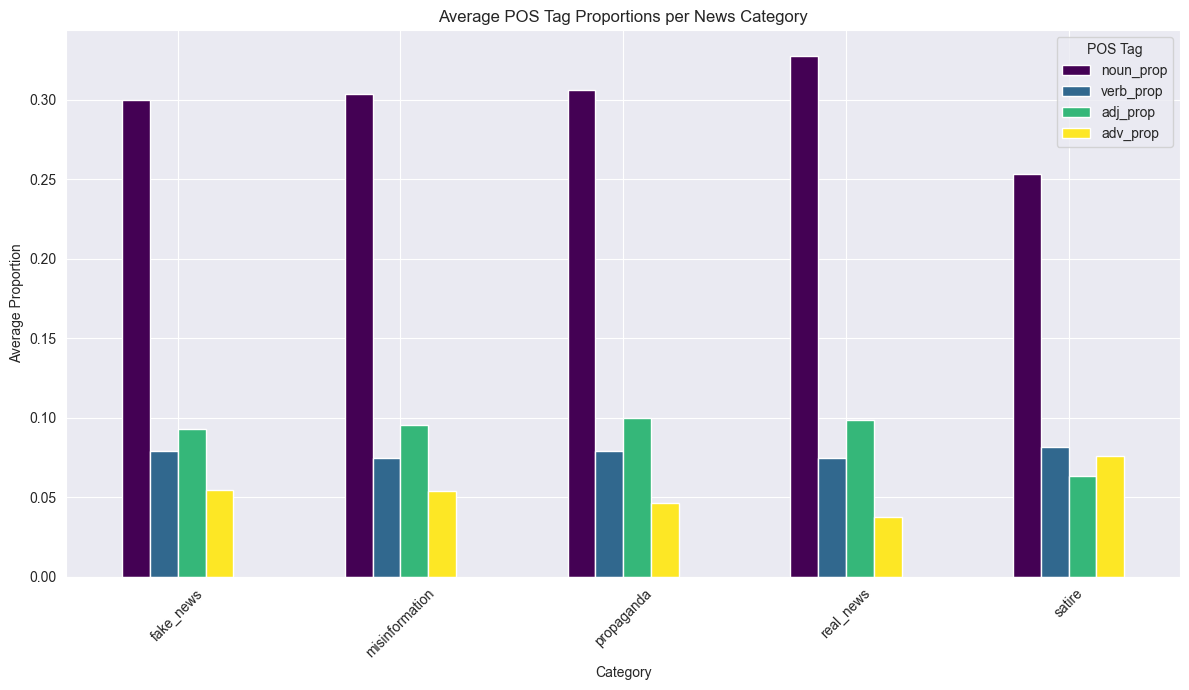

In [7]:
print("\n--- POS Tag Analysis ---")

# 1. Count specific POS tags (NOUN, VERB, ADJ, ADV) per document
def count_pos_tags(tags_list):
    tag_counts = Counter(tags_list)
    return {
        'noun_count': tag_counts.get('NOUN', 0),
        'verb_count': tag_counts.get('VERB', 0),
        'adj_count': tag_counts.get('ADJ', 0), # Adjectives
        'adv_count': tag_counts.get('ADV', 0)  # Adverbs
    }

pos_counts = df_processed['pos_tags'].apply(lambda x: pd.Series(count_pos_tags(x)))
df_processed = pd.concat([df_processed, pos_counts], axis=1)
print("Added POS count columns (noun_count, verb_count, adj_count, adv_count).")

# 2. Calculate POS Proportions (relative to total tags per document)
# Avoid division by zero if pos_tags list is empty
df_processed['total_tags'] = df_processed['pos_tags'].apply(len)
df_processed['noun_prop'] = df_processed['noun_count'] / df_processed['total_tags'].replace(0, 1) # Avoid division by zero
df_processed['verb_prop'] = df_processed['verb_count'] / df_processed['total_tags'].replace(0, 1)
df_processed['adj_prop'] = df_processed['adj_count'] / df_processed['total_tags'].replace(0, 1)
df_processed['adv_prop'] = df_processed['adv_count'] / df_processed['total_tags'].replace(0, 1)
print("Added POS proportion columns (noun_prop, verb_prop, adj_prop, adv_prop).")


# 3. Aggregate POS proportions per Category
print("\nAverage POS Proportions per Category:")
pos_prop_stats = df_processed.groupby('tag')[['noun_prop', 'verb_prop', 'adj_prop', 'adv_prop']].mean()
print(pos_prop_stats)

# 4. Visualize POS Proportions
pos_prop_stats.plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Average POS Tag Proportions per News Category')
plt.xlabel('Category')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45)
plt.legend(title='POS Tag')
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'pos_proportion_comparison.png'))
print(f"\nSaved POS proportion comparison plot to {VISUALIZATIONS_DIR}")
# plt.show()


--- NER Analysis ---
                                                content             tag  \
0     atacul iudeilor asupra libertății de exprimare...       fake_news   
1     planurile autorităților moldovenești de organi...  misinformation   
2     transfuziile cu sânge care provin de la persoa...       fake_news   
3     operațiunea militară specială este nouă etapă ...      propaganda   
4     joe biden declarat cea mai sfântă dintre sărbă...  misinformation   
...                                                 ...             ...   
4329  deşi fost un an dificil bilanţul lui bill gate...          satire   
4330  la protestul anti covid de la cluj nu adus nim...          satire   
4331  la protestul anti covid de la cluj nu venit ni...          satire   
4332  în protestul anti covid de în cluj nu venit ni...          satire   
4333  la protestul anti covid de la cluj nu venit ni...          satire   

                                                 lemmas  \
0     [atac, iudei

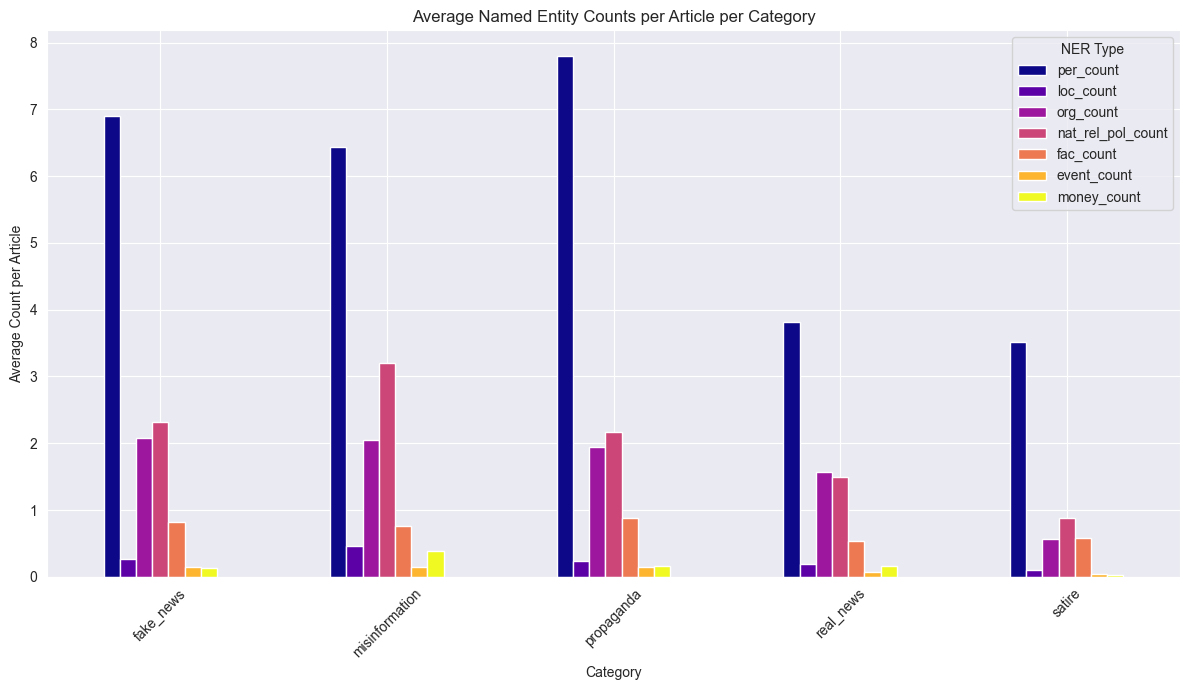

In [8]:
print("\n--- NER Analysis ---")

# 1. Count specific NER types (PER, LOC, ORG, MISC) per document
# spaCy NER labels for Romanian might include others, adjust as needed based on model output
# Common labels: PER (Person), LOC (Location), ORG (Organization), MISC (Miscellaneous)
def count_ner_types(entities_list):
    # entities_list is a list of tuples like [(text, label), ...]
    labels = [label for text, label in entities_list]
    ner_counts = Counter(labels)
    return {
        'per_count': ner_counts.get('PERSON', 0),
        'nat_rel_pol_count': ner_counts.get('NAT_REL_POL', 0),
        'org_count': ner_counts.get('ORGANIZATION', 0),
        'fac_count': ner_counts.get('FACILITY', 0),
        'event_count': ner_counts.get('EVENT', 0),
        'money_count': ner_counts.get('MONEY', 0),
        'loc_count': ner_counts.get('LOC', 0)
    }

ner_counts = df_processed['entities'].apply(lambda x: pd.Series(count_ner_types(x)))
df_processed = pd.concat([df_processed, ner_counts], axis=1)
print(df_processed)
df_processed['total_entities'] = df_processed['per_count'] + df_processed['nat_rel_pol_count'] + df_processed['org_count'] + df_processed['fac_count'] + df_processed['event_count'] + df_processed['money_count'] + df_processed['loc_count']
print("Added NER count columns (per_count, nat_rel_pol_count, org_count, fac_count, event_count, money_count, loc_count, total_entities).")

# 2. Aggregate NER counts per Category (using mean count per article)
print("\nAverage NER Counts per Article per Category:")
ner_mean_stats = df_processed.groupby('tag')[['per_count', 'loc_count', 'org_count', 'nat_rel_pol_count', 'fac_count', 'event_count', 'money_count', 'total_entities']].mean()
print(ner_mean_stats)

# 3. Visualize Average NER Counts
ner_mean_stats[['per_count', 'loc_count', 'org_count', 'nat_rel_pol_count', 'fac_count', 'event_count','money_count']].plot(kind='bar', figsize=(12, 7), colormap='plasma')
plt.title('Average Named Entity Counts per Article per Category')
plt.xlabel('Category')
plt.ylabel('Average Count per Article')
plt.xticks(rotation=45)
plt.legend(title='NER Type')
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'ner_count_comparison.png'))
print(f"\nSaved NER count comparison plot to {VISUALIZATIONS_DIR}")
# plt.show()

# 4. (Optional) Analyze Top Entities per Category (Example for PER - Persons)
def get_top_entities(entities_list, entity_type='PERSON', top_n=10):
    entities = [text.lower() for text, label in entities_list if label == entity_type]
    return Counter(entities).most_common(top_n)

print("\n--- Top Entities (Example: PER) ---")
for category in df_processed['tag'].unique():
    print(f"\nTop {category.upper()} Persons:")
    # Concatenate all entity lists for the category
    all_entities_in_category = df_processed[df_processed['tag'] == category]['entities'].sum()
    top_persons = get_top_entities(all_entities_in_category, entity_type='PERSON', top_n=10)
    print(top_persons if top_persons else "None found")

# Emotion Analysis

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast # For parsing list columns if reloading df_processed
import numpy as np # For potential numeric operations or radar chart
from math import pi # For radar chart calculations

In [10]:
print("\n--- Loading RoEmoLex Lexicon ---")

# Try loading with different encodings if UTF-8 fails, as per PDF suggestion
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-2']
df_roemo_words = None

for encoding in encodings_to_try:
    try:
        # Attempt to load the single-word lexicon
        # We might need to inspect the file first to confirm the delimiter (e.g., ',', ';', '\t')
        # Let's assume comma for now, adjust if needed.
        df_roemo_words = pd.read_csv(ROEMOLEX_WORDS_PATH, encoding=encoding, delimiter=';') # ADJUST DELIMITER IF NEEDED
        print(f"Successfully loaded RoEmoLex words with encoding: {encoding}")
        break # Stop trying encodings if successful
    except FileNotFoundError:
        print(f"Error: RoEmoLex words file not found at {ROEMOLEX_WORDS_PATH}")
        break # Stop if file not found
    except UnicodeDecodeError:
        print(f"Failed to load RoEmoLex words with encoding: {encoding}")
    except Exception as e:
        print(f"An unexpected error occurred loading RoEmoLex words: {e}")
        break # Stop on other errors


--- Loading RoEmoLex Lexicon ---
Successfully loaded RoEmoLex words with encoding: utf-8


In [11]:
# Proceed only if the lexicon loaded
if df_roemo_words is not None:
    print("\nRoEmoLex Words Lexicon Info:")
    print(f"Shape: {df_roemo_words.shape}")
    print("Columns:", df_roemo_words.columns.tolist())
    print("\nFirst 5 rows:\n", df_roemo_words.head())
    print("\nData types:\n", df_roemo_words.dtypes)

    # --- Identify Lexicon Columns ---
    # Based on the PDF description and typical lexicon structure. **VERIFY THESE AGAINST YOUR FILE'S ACTUAL COLUMNS**
    LEMMA_COL = 'word' # Replace with actual lemma column name if different
    EMOTION_COLS = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
    POLARITY_COLS = ['Positivity', 'Negativity']
    ALL_SCORE_COLS = EMOTION_COLS + POLARITY_COLS

    # Check if expected columns exist
    missing_cols = [col for col in [LEMMA_COL] + ALL_SCORE_COLS if col not in df_roemo_words.columns]
    if missing_cols:
        print(f"\nERROR: Expected columns missing in RoEmoLex words file: {missing_cols}")
        print(f"Available columns: {df_roemo_words.columns.tolist()}")
        # Stop execution if critical columns are missing
        df_roemo_words = None # Indicate failure
    else:
         print("\nAll expected lexicon columns found.")
         # Ensure score columns are numeric, convert if necessary
         for col in ALL_SCORE_COLS:
              df_roemo_words[col] = pd.to_numeric(df_roemo_words[col], errors='coerce')
         # Fill any NaNs introduced by coercion (e.g., non-numeric values) with 0
         df_roemo_words[ALL_SCORE_COLS] = df_roemo_words[ALL_SCORE_COLS].fillna(0).astype(int) # Or float if needed
         print("Score columns converted to numeric.")


RoEmoLex Words Lexicon Info:
Shape: (8486, 14)
Columns: ['Unnamed: 0', 'word', 'part_of_speech', 'Positivity', 'Negativity', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'wn_synset_id']

First 5 rows:
    Unnamed: 0         word part_of_speech  Positivity  Negativity  Anger  \
0           0      se izbi           Verb           0           1      0   
1           1         bate           Verb           0           1      1   
2           3         abac           Noun           0           0      0   
3           4  numărătoare           Noun           0           0      0   
4           5      abandon           Noun           0           1      0   

   Anticipation  Disgust  Fear  Joy  Sadness  Surprise  Trust  \
0             0        0     1    0        1         1      0   
1             0        0     1    0        0         0      0   
2             0        0     0    0        0         0      1   
3             0        0     0    0       

In [12]:
# --- Create Lookup Dictionary (if lexicon loaded successfully) ---
roemo_dict = {}
if df_roemo_words is not None:
    print("\n--- Creating RoEmoLex Lookup Dictionary (from words file) ---")
    # Convert lemma column to lowercase for case-insensitive matching
    df_roemo_words[LEMMA_COL] = df_roemo_words[LEMMA_COL].str.lower()

    # Handle potential duplicate lemmas (e.g., same lemma with different POS)
    # Strategy: Keep the first occurrence's scores. Could also average, etc.
    df_roemo_unique = df_roemo_words.drop_duplicates(subset=[LEMMA_COL], keep='first')
    print(f"Dropped {len(df_roemo_words) - len(df_roemo_unique)} duplicate lemmas, keeping first entry.")

    # Create the dictionary: {lemma: {emotion1: score1, ..., polarity1: scoreN}}
    for index, row in df_roemo_unique.iterrows():
        lemma = row[LEMMA_COL]
        scores = row[ALL_SCORE_COLS].to_dict()
        roemo_dict[lemma] = scores

    print(f"RoEmoLex dictionary created with {len(roemo_dict)} unique lemmas.")
    # Optional: print a sample entry
    sample_lemma = list(roemo_dict.keys())[0]
    print(f"Sample entry for '{sample_lemma}': {roemo_dict[sample_lemma]}")

else:
    print("\nSkipping RoEmoLex dictionary creation because the lexicon file failed to load or columns were missing.")


--- Creating RoEmoLex Lookup Dictionary (from words file) ---
Dropped 2156 duplicate lemmas, keeping first entry.
RoEmoLex dictionary created with 6330 unique lemmas.
Sample entry for 'se izbi': {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, 'Fear': 1, 'Joy': 0, 'Sadness': 1, 'Surprise': 1, 'Trust': 0, 'Positivity': 0, 'Negativity': 1}


In [ ]:
# --- Load RoEmoLex Expressions (Optional - for potential future use) ---
# We will focus on the single-word dict for now, but you might load the expressions file similarly
# df_roemo_expr = pd.read_csv(ROEMOLEX_EXPR_PATH, ...)
# print(f"\nLoaded RoEmoLex expressions file (shape: {df_roemo_expr.shape if 'df_roemo_expr' in locals() else 'Not loaded'})")

In [13]:
NEW_COUNT_COL = 'matched_emotion_words'
ALL_ANALYSIS_COLS = ALL_SCORE_COLS + [NEW_COUNT_COL]

In [14]:
# --- Emotion Scoring Function ---
def calculate_emotion_scores(lemma_list, lexicon_dict):
    # Initialize scores for the document
    doc_scores = {col: 0 for col in ALL_SCORE_COLS}
    matched_words = 0
    if not isinstance(lemma_list, list): # Handle potential non-list input
        doc_scores[NEW_COUNT_COL] = matched_words 
        return doc_scores

    for lemma in lemma_list:
        lemma_lower = lemma.lower() # Match in lowercase
        if lemma_lower in lexicon_dict:
            matched_words += 1
            lemma_scores = lexicon_dict[lemma_lower]
            for emotion_or_polarity, score in lemma_scores.items():
                doc_scores[emotion_or_polarity] += score

    doc_scores[NEW_COUNT_COL] = matched_words
    return doc_scores


--- Applying Emotion Scoring to DataFrame ---
Calculating scores and matched word count for each document...
Emotion scoring finished in 0.78 seconds.
Added emotion and polarity scores and matched emotion words columns to DataFrame.
Columns added: ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'Positivity', 'Negativity', 'matched_emotion_words']

DataFrame head with scores and emotional word count:
    Anger  Anticipation  Disgust  Fear  Joy  Sadness  Surprise  Trust  \
0      5             2        4     7    1        3         1      4   
1      0             2        0     0    0        0         0      6   
2      3             6        2     3    1        5         0      6   
3      2             3        0     3    2        0         1      1   
4      1             1        1     1    5        0         1      4   

   Positivity  Negativity  matched_emotion_words  
0           2           9                     16  
1           3           

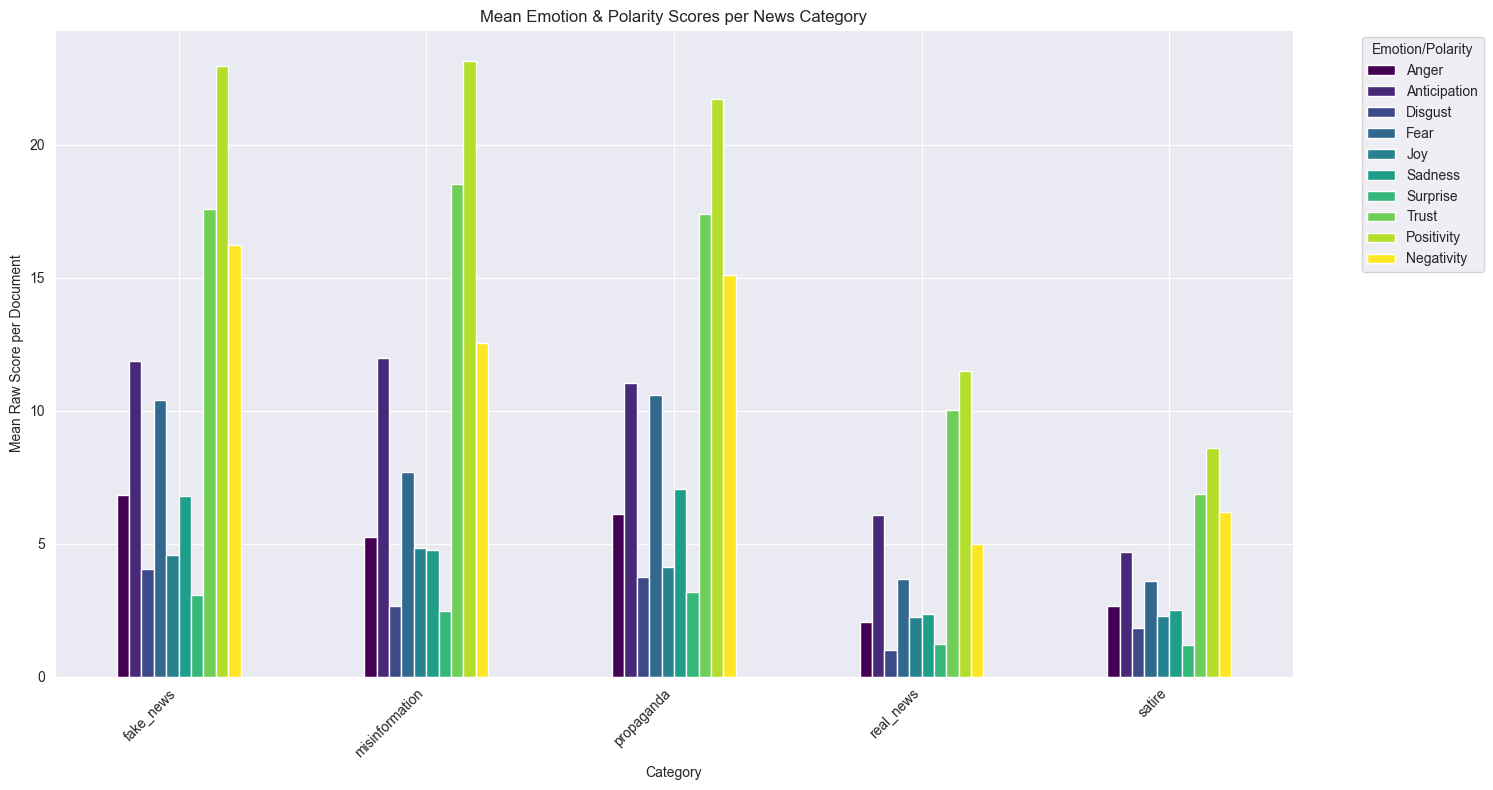

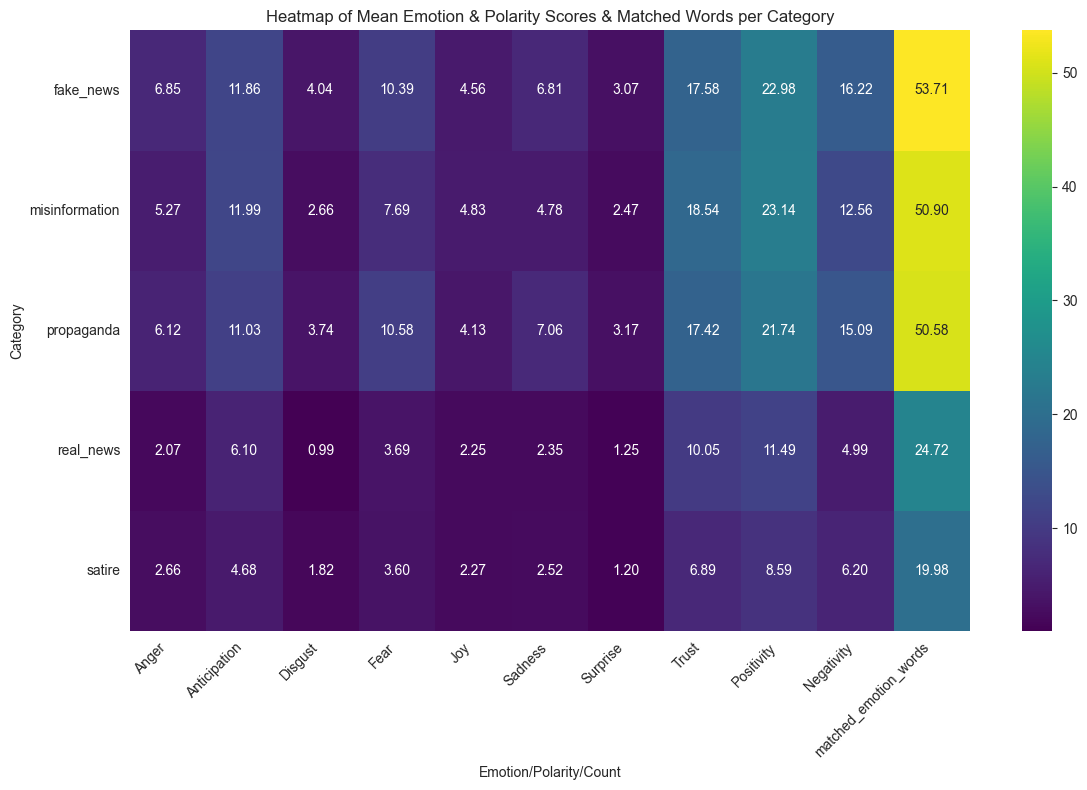

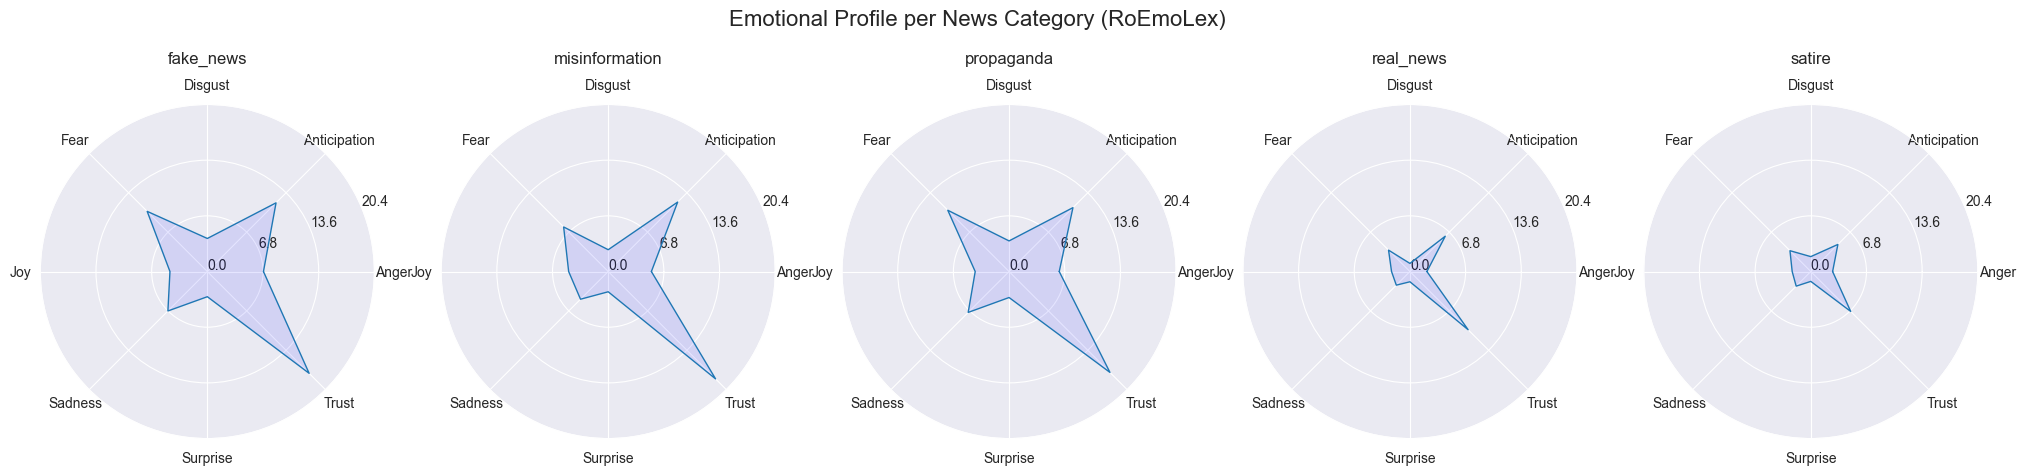

In [15]:
# --- Apply Scoring to DataFrame (if dictionary exists) ---
if roemo_dict:
    print("\n--- Applying Emotion Scoring to DataFrame ---")
    print("Calculating scores and matched word count for each document...")
    start_time = time.time()

    # Apply the function to the 'lemmas' column (contains all lemmas)
    analysis_scores_list = df_processed['lemmas'].apply(lambda x: calculate_emotion_scores(x, roemo_dict))

    # Convert the list of score dictionaries into a DataFrame
    analysis_scores_df = pd.json_normalize(analysis_scores_list)
    analysis_scores_df.index = df_processed.index # Align index

    # Add the score columns to the main DataFrame
    # Drop existing score columns if rerunning
    cols_to_drop = [col for col in analysis_scores_df.columns if col in df_processed.columns]
    if cols_to_drop:
         print(f"Dropping existing score columns: {cols_to_drop}")
         df_processed = df_processed.drop(columns=cols_to_drop)

    df_processed = pd.concat([df_processed, analysis_scores_df], axis=1)

    end_time = time.time()
    print(f"Emotion scoring finished in {end_time - start_time:.2f} seconds.")
    print("Added emotion and polarity scores and matched emotion words columns to DataFrame.")
    print("Columns added:", analysis_scores_df.columns.tolist())
    print("\nDataFrame head with scores and emotional word count:\n", df_processed[ALL_ANALYSIS_COLS].head())

    # --- Analyze Emotion Distribution per Category ---
    print("\n--- Analyzing Mean Emotion/Polarity Scores & Emotional Word Count per Category ---")
    # Ensure 'tag' column exists
    if 'tag' in df_processed.columns:
         emotion_analysis = df_processed.groupby('tag')[ALL_ANALYSIS_COLS].mean()
         print(emotion_analysis)

         # --- Visualize Emotion Distribution ---
         print("\n--- Visualizing Emotion Distributions ---")

         # 1. Bar Chart of Mean Scores (Emotions & Polarity only)
         emotion_analysis[ALL_SCORE_COLS].plot(kind='bar', figsize=(15, 8), colormap='viridis')
         plt.title('Mean Emotion & Polarity Scores per News Category')
         plt.xlabel('Category')
         plt.ylabel('Mean Raw Score per Document')
         plt.xticks(rotation=45, ha='right')
         plt.legend(title='Emotion/Polarity', bbox_to_anchor=(1.05, 1), loc='upper left')
         plt.tight_layout()
         plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'mean_emotion_scores_bar_revised.png'))
         print(f"\nSaved mean emotion scores bar chart to {VISUALIZATIONS_DIR}")
         # plt.show()

         # 2. Bar Chart of Mean Matched Emotion Words
         plt.figure(figsize=(10, 6))
         emotion_analysis[NEW_COUNT_COL].plot(kind='bar', color='skyblue')
         plt.title(f'Mean Number of Matched Emotion Words ({NEW_COUNT_COL}) per Category')
         plt.xlabel('Category')
         plt.ylabel('Average Count per Document')
         plt.xticks(rotation=45, ha='right')
         plt.tight_layout()
         plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'mean_matched_words_bar.png'))
         print(f"Saved mean matched words bar chart to {VISUALIZATIONS_DIR}")
         plt.close() # Close plot
        
         # 3. Heatmap of Mean Scores (Including matched words count)
         plt.figure(figsize=(12, 8))
         sns.heatmap(emotion_analysis, annot=True, cmap="viridis", fmt=".2f")
         plt.title('Heatmap of Mean Emotion & Polarity Scores & Matched Words per Category')
         plt.xlabel('Emotion/Polarity/Count')
         plt.ylabel('Category')
         plt.xticks(rotation=45, ha='right')
         plt.yticks(rotation=0)
         plt.tight_layout()
         plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'mean_emotion_scores_heatmap_revised.png'))
         print(f"\nSaved mean emotion scores heatmap to {VISUALIZATIONS_DIR}")
         # plt.show()


         # 4. Radar Charts (one per category) - Focus only on the 8 emotions
         categories = emotion_analysis.index.tolist()
         emotion_labels = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']# EMOTION_COLS
         num_vars = len(emotion_labels)

         # Compute angle for each axis
         angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
         angles += angles[:1] # Close the plot

         fig, axs = plt.subplots(nrows=1, ncols=len(categories), figsize=(5 * len(categories), 5),
                                 subplot_kw=dict(polar=True))
         fig.suptitle('Emotional Profile per News Category (RoEmoLex)', fontsize=16, y=1.02)

         # Ensure axs is iterable even if only one category
         if len(categories) == 1: axs = [axs]

         for i, (category, ax) in enumerate(zip(categories, axs)):
             # Get data for the category, ensure it's a list/array
             values = emotion_analysis.loc[category, emotion_labels].values.flatten().tolist()
             values += values[:1] # Close the plot

             ax.set_xticks(angles[:-1])
             ax.set_xticklabels(emotion_labels)

             # Pre-calculate y-axis limits based on max value across all categories for consistency
             max_val = emotion_analysis[emotion_labels].max().max()
             ax.set_yticks(np.linspace(0, max_val * 1.1, 4)) # Adjust number of ticks if needed
             ax.set_ylim(0, max_val * 1.1) # Add a little buffer

             # Plot data
             ax.plot(angles, values, linewidth=1, linestyle='solid', label=category)
             ax.fill(angles, values, 'b', alpha=0.1) # Fill area

             ax.set_title(category, size=12, y=1.1)

         # Adjust layout if needed - tight_layout doesn't work well with polar subplots sometimes
         # fig.tight_layout(pad=3.0) # Might need manual adjustment
         plt.savefig(os.path.join(VISUALIZATIONS_DIR, 'emotion_radar_charts.png'), bbox_inches='tight')
         print(f"\nSaved emotion radar charts to {VISUALIZATIONS_DIR}")
         # plt.show()

    else:
         print("\nSkipping emotion aggregation/visualization because 'tag' column is missing.")

else:
    print("\nSkipping emotion scoring and analysis because RoEmoLex dictionary was not created.")


In [16]:
print(emotion_analysis)

                   Anger  Anticipation   Disgust       Fear       Joy  \
tag                                                                     
fake_news       6.850985     11.860837  4.035714  10.389163  4.564039   
misinformation  5.271834     11.994541  2.663755   7.694323  4.828603   
propaganda      6.125000     11.028409  3.738636  10.579545  4.133523   
real_news       2.072674      6.100775  0.990310   3.690891  2.245155   
satire          2.663218      4.677011  1.819540   3.596552  2.272414   

                 Sadness  Surprise      Trust  Positivity  Negativity  \
tag                                                                     
fake_news       6.810345  3.073892  17.576355   22.976601   16.221675   
misinformation  4.780568  2.471616  18.538210   23.141921   12.563319   
propaganda      7.058239  3.173295  17.416193   21.738636   15.089489   
real_news       2.352713  1.250969  10.048450   11.486434    4.992248   
satire          2.522989  1.203448   6.889655    8

# Word Clouds

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import pandas as pd

In [18]:
# --- Check Prerequisites ---
if 'df_processed' not in locals() or df_processed is None:
    print("Error: df_processed DataFrame not found. Please run previous analysis steps.")
    exit()
if 'lemmas_filtered' not in df_processed.columns:
    print("Error: 'lemmas_filtered' column not found. Rerun preprocessing steps.")
    exit()
# Ensure lemmas_filtered contains lists
if not isinstance(df_processed['lemmas_filtered'].iloc[0], list):
     print("Warning: 'lemmas_filtered' column might not be parsed as lists. Attempting conversion...")
     try:
         df_processed['lemmas_filtered'] = df_processed['lemmas_filtered'].apply(parse_list_literal) # Function from Step 4
         if not isinstance(df_processed['lemmas_filtered'].iloc[0], list):
              raise ValueError("Conversion failed")
         print("'lemmas_filtered' column converted to lists.")
     except Exception as e:
          print(f"Error converting 'lemmas_filtered': {e}. Word cloud generation may fail.")
          # exit()

# Check if roemo_dict exists for emotional clouds (it might not if lexicon loading failed)
can_generate_emotional_clouds = 'roemo_dict' in locals() and bool(roemo_dict)
if not can_generate_emotional_clouds:
    print("\nWarning: RoEmoLex dictionary ('roemo_dict') not found or empty. Skipping emotional word clouds.")

In [19]:
print("\n--- Generating Word Clouds ---")

# Define WordCloud settings
wc_width = 800
wc_height = 400
wc_background = "white"
wc_colormap = "viridis" # Choose a colormap

# Get unique categories
categories = df_processed['tag'].unique()

for category in categories:
    print(f"\nProcessing category: {category}")

    # Filter DataFrame for the current category
    df_category = df_processed[df_processed['tag'] == category]

    # --- Standard Word Cloud ---
    try:
        # Concatenate all filtered lemmas for the category into a single list
        # Using list comprehension and extend for potentially better memory usage than sum()
        all_lemmas_list = []
        for lemma_list in df_category['lemmas_filtered']:
             if isinstance(lemma_list, list): # Ensure it's a list
                 all_lemmas_list.extend(lemma_list)

        # Join the list into a single string
        text_standard = " ".join(all_lemmas_list)

        if not text_standard:
            print(f"  - No words found for standard word cloud in category '{category}'. Skipping.")
        else:
            print(f"  - Generating standard word cloud for '{category}'...")
            wordcloud_standard = WordCloud(width=wc_width, height=wc_height,
                                           background_color=wc_background,
                                           colormap=wc_colormap,
                                           # max_words=200, # Optional: limit number of words
                                           contour_width=1, contour_color='steelblue',
                                           collocations=False # Disable bigrams/trigrams if desired
                                          ).generate(text_standard)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud_standard, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Standard Word Cloud - {category}", fontsize=14)
            # Save the image
            std_wc_filename = f"standard_wc_{category.replace(' ', '_')}.png"
            plt.savefig(os.path.join(WORDCLOUD_DIR, std_wc_filename), bbox_inches='tight')
            print(f"  - Saved standard word cloud to: {WORDCLOUD_DIR}")
            plt.close() # Close the plot to free memory

    except Exception as e:
        print(f"  - Error generating standard word cloud for '{category}': {e}")
        import traceback
        traceback.print_exc() # Print traceback for debugging

    # --- Emotional Word Cloud (Conditional) ---
    if can_generate_emotional_clouds:
        try:
            # Filter the concatenated list to include only lemmas present in RoEmoLex
            emotional_lemmas_list = [lemma for lemma in all_lemmas_list if lemma in roemo_dict] # Assumes lemmas are already lowercase if needed

            # Join the filtered list into a single string
            text_emotional = " ".join(emotional_lemmas_list)

            if not text_emotional:
                print(f"  - No emotional words found for word cloud in category '{category}'. Skipping.")
            else:
                print(f"  - Generating emotional word cloud for '{category}'...")
                wordcloud_emotional = WordCloud(width=wc_width, height=wc_height,
                                               background_color=wc_background,
                                               colormap=wc_colormap, # Could use a different colormap
                                               contour_width=1, contour_color='firebrick',
                                               collocations=False
                                              ).generate(text_emotional)

                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud_emotional, interpolation='bilinear')
                plt.axis("off")
                plt.title(f"Emotional Word Cloud (RoEmoLex) - {category}", fontsize=14)
                # Save the image
                emo_wc_filename = f"emotional_wc_{category.replace(' ', '_')}.png"
                plt.savefig(os.path.join(EMOTIONAL_WORDCLOUD_DIR, emo_wc_filename), bbox_inches='tight')
                print(f"  - Saved emotional word cloud to: {EMOTIONAL_WORDCLOUD_DIR}")
                plt.close() # Close the plot

        except Exception as e:
            print(f"  - Error generating emotional word cloud for '{category}': {e}")
            import traceback
            traceback.print_exc()

print("\n--- Word cloud generation complete. ---")


--- Generating Word Clouds ---

Processing category: fake_news
  - Generating standard word cloud for 'fake_news'...
  - Saved standard word cloud to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\word_clouds
  - Generating emotional word cloud for 'fake_news'...
  - Saved emotional word cloud to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotional_wordclouds

Processing category: misinformation
  - Generating standard word cloud for 'misinformation'...
  - Saved standard word cloud to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\word_clouds
  - Generating emotional word cloud for 'misinformation'...
  - Saved emotional word cloud to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotional_wordclouds

Processing category: propaganda
  - Generating standard word cloud for 'propag

In [20]:
print(df_processed)

                                                content             tag  \
0     atacul iudeilor asupra libertății de exprimare...       fake_news   
1     planurile autorităților moldovenești de organi...  misinformation   
2     transfuziile cu sânge care provin de la persoa...       fake_news   
3     operațiunea militară specială este nouă etapă ...      propaganda   
4     joe biden declarat cea mai sfântă dintre sărbă...  misinformation   
...                                                 ...             ...   
4329  deşi fost un an dificil bilanţul lui bill gate...          satire   
4330  la protestul anti covid de la cluj nu adus nim...          satire   
4331  la protestul anti covid de la cluj nu venit ni...          satire   
4332  în protestul anti covid de în cluj nu venit ni...          satire   
4333  la protestul anti covid de la cluj nu venit ni...          satire   

                                                 lemmas  \
0     [atac, iudeilor, asupra, libertate

In [22]:
output_path = os.path.join(BASE_DIR, 'data', 'processed', 'NEW.csv')
df_processed.to_csv(output_path, index=False, encoding='utf-8')